# Draw insights from car accident reports
This notebook shows you how to analyze car vehicle accidents based on accident reports for New York. The analysis steps in the notebook show how you can use the information about accidents to learn more about the possible causes for collisions. You will learn how to install additional Python packages, how to add external PySpark modules, and how to perform descriptive data analysis.

This notebook runs on Python 2 with Spark 2.1

## Table of contents
- [Get data](#get_data)
- [Access data](#access_data)
- [Create Spark SQL DataFrame](#create_spark_sql _dataframe)
- [Load visualization packages](#load_visualization_packages)
- [Explore data](#explore_data)
- [Clean and shape the data](#data_cleaning)
- [Summary](#summary)
<a id="get_data"></a>

## Get data

Begin by getting the data about car accidents in the New York area. Click [NYPD Motor Vehicle Collisions](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95) to access the data set. Then click **Export** to download the data as a CSV file. 

This data set covers all reported vehicle collisions in New York starting in July 2012 until today  and contains detailed information about the incidents.

After you download the file, load the data file to the notebook by clicking the **Find and Add Data** icon on the notebook action bar. Select the **Files** tab and browse to the data file. 

**Note**: Because the CSV file is relatively large, it may take a few minutes until the data file is loaded. 

This file is stored in the Object Storage instance that is associated with your project.

<a id="access_data"></a>
## Load data

Before you can access data in the data file in Object Storage, you must set the Hadoop configuration with the Object Storage credentials.

**Note**: You will not be using Hadoop in this sample; however Spark leverages some Hadoop components.

To add the code to access the data file which is stored in Object Storage and set the Hadoop configuration, click the next code cell and select **Insert to code>Insert SparkSession DataFrame** on the data file in the `Data` pane in the notebook.

This function inserts the setup code for the preconfigured [`SparkContext`](https://spark.apache.org/docs/1.6.0/api/python/pyspark.html#pyspark.SparkContext). Then the data is loaded into a `Spark DataFrame` which is created by using `SparkContext`.

The credentials for accessing the CSV file are included in the generated code. 

In [332]:
import ibmos2spark

# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': '<your project id>',
    'region': 'dallas',
    'user_id': '<your userid>',
    'username': '<your username>',
    'password': '<your password>'
}

configuration_name = 'os_ab41a7e5197c4067a837c191f6e7663c_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)

from pyspark.sql import SparkSession, Row
spark = SparkSession.builder.getOrCreate()
collisions = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(bmos.url('Spark16toSpark20', 'NYPD_Motor_Vehicle_Collisions(1).csv'))
collisions.take(5)

[Row(DATE=u'07/15/2017', TIME=u'0:00', BOROUGH=u'BRONX', ZIP CODE=u'10466', LATITUDE=u'40.89431', LONGITUDE=u'-73.85184', LOCATION=u'(40.89431, -73.85184)', ON STREET NAME=None, CROSS STREET NAME=None, OFF STREET NAME=u'4252      DIGNEY AVENUE                 ', NUMBER OF PERSONS INJURED=u'0', NUMBER OF PERSONS KILLED=u'0', NUMBER OF PEDESTRIANS INJURED=u'0', NUMBER OF PEDESTRIANS KILLED=u'0', NUMBER OF CYCLIST INJURED=u'0', NUMBER OF CYCLIST KILLED=u'0', NUMBER OF MOTORIST INJURED=u'0', NUMBER OF MOTORIST KILLED=u'0', CONTRIBUTING FACTOR VEHICLE 1=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 2=None, CONTRIBUTING FACTOR VEHICLE 3=None, CONTRIBUTING FACTOR VEHICLE 4=None, CONTRIBUTING FACTOR VEHICLE 5=None, UNIQUE KEY=u'3711930', VEHICLE TYPE CODE 1=u'PICK-UP TRUCK', VEHICLE TYPE CODE 2=None, VEHICLE TYPE CODE 3=None, VEHICLE TYPE CODE 4=None, VEHICLE TYPE CODE 5=None),
 Row(DATE=u'07/15/2017', TIME=u'0:00', BOROUGH=u'BROOKLYN', ZIP CODE=u'11207', LATITUDE=u'40.65386', LONGITUDE=u'-73.88

In [3]:
collisions.cache()

DataFrame[DATE: string, TIME: string, BOROUGH: string, ZIP CODE: string, LATITUDE: string, LONGITUDE: string, LOCATION: string, ON STREET NAME: string, CROSS STREET NAME: string, OFF STREET NAME: string, NUMBER OF PERSONS INJURED: string, NUMBER OF PERSONS KILLED: string, NUMBER OF PEDESTRIANS INJURED: string, NUMBER OF PEDESTRIANS KILLED: string, NUMBER OF CYCLIST INJURED: string, NUMBER OF CYCLIST KILLED: string, NUMBER OF MOTORIST INJURED: string, NUMBER OF MOTORIST KILLED: string, CONTRIBUTING FACTOR VEHICLE 1: string, CONTRIBUTING FACTOR VEHICLE 2: string, CONTRIBUTING FACTOR VEHICLE 3: string, CONTRIBUTING FACTOR VEHICLE 4: string, CONTRIBUTING FACTOR VEHICLE 5: string, UNIQUE KEY: string, VEHICLE TYPE CODE 1: string, VEHICLE TYPE CODE 2: string, VEHICLE TYPE CODE 3: string, VEHICLE TYPE CODE 4: string, VEHICLE TYPE CODE 5: string]

In [4]:
print("Records: {}".format(collisions.count()))
collisions.printSchema()

Records: 1101146
root
 |-- DATE: string (nullable = true)
 |-- TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: string (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: string (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: strin

<a id="load_visualization_packages"></a> 
## Load visualization packages

To plot data, this notebook will use the following two packages, which you need to import or install:

- [Matplotlib](http://matplotlib.org/), a basic plotting library for Python
- [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/), a statistical data visualization library

The `seaborn` package is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics. You must install the `seaborn` package by using `!pip`.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
#adjust settings
%matplotlib inline
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 12)

In [6]:
collisions_df = collisions
collisions_pd = collisions_df[collisions_df['LATITUDE'] != 0][['LATITUDE', 'LONGITUDE', 'DATE', 'TIME',
                                                               'BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME',
                                                               'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                                                               'CONTRIBUTING FACTOR VEHICLE 1']].toPandas()

collisions_pd.columns = ['Latitude', 'Longitude', 'Date', 'Time', 'Borough', 'On Street',
                         'Cross Street', 'Persons Injured', 'Persons Killed', 'Contributing Factor']

collisions_pd['Latitude'] = collisions_pd['Latitude'].astype(float)
collisions_pd['Longitude'] = collisions_pd['Longitude'].astype(float)
collisions_pd['Persons Killed'] = collisions_pd['Persons Killed'].astype(float)
collisions_pd['Persons Injured'] = collisions_pd['Persons Injured'].astype(float)



#divide dataset in accidents which are: fatal, non-lethal but with person damage, non of the above
killed_pd = collisions_pd[collisions_pd['Persons Killed']!=0]
injured_pd = collisions_pd[np.logical_and(collisions_pd['Persons Injured']!=0, collisions_pd['Persons Killed']==0)]
nothing_pd = collisions_pd[np.logical_and(collisions_pd['Persons Killed']==0, collisions_pd['Persons Injured']==0)]

### Create an explorative scatter plot of the data

Using an explorative scatter plot is a way to analyze certain characteristics of the data set. 

Create an intial explorative scatter plot of all collisions by using the latitude and longitude information in the raw data:

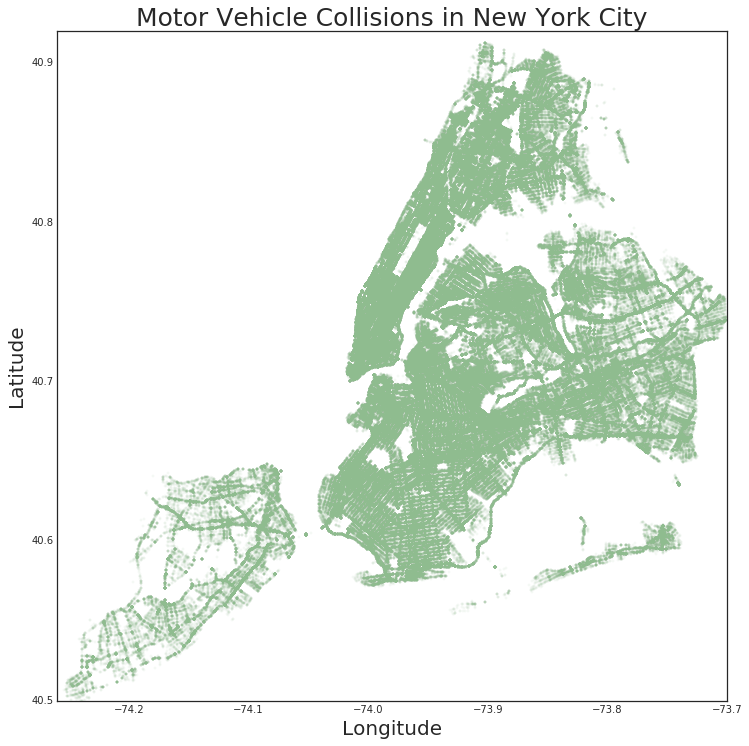

In [7]:
#create scatterplots
plt.scatter(collisions_pd.Longitude, collisions_pd.Latitude, alpha=0.05, s=4, color='darkseagreen')

#adjust more settings
plt.title('Motor Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)

plt.show()

Although this scatter plot is not a street map of New York City, the scatter plot dots roughly correspond to the street map of New York City. You see very few collisions in Central Park or on bridges, as opposed to street crossings and curves, where there is a noticeably higher density of collisions.

### Enhance the scatter plot with information about city boroughs

Now add information about the city boroughs and use a different color to depict each borough on the scatter plot:


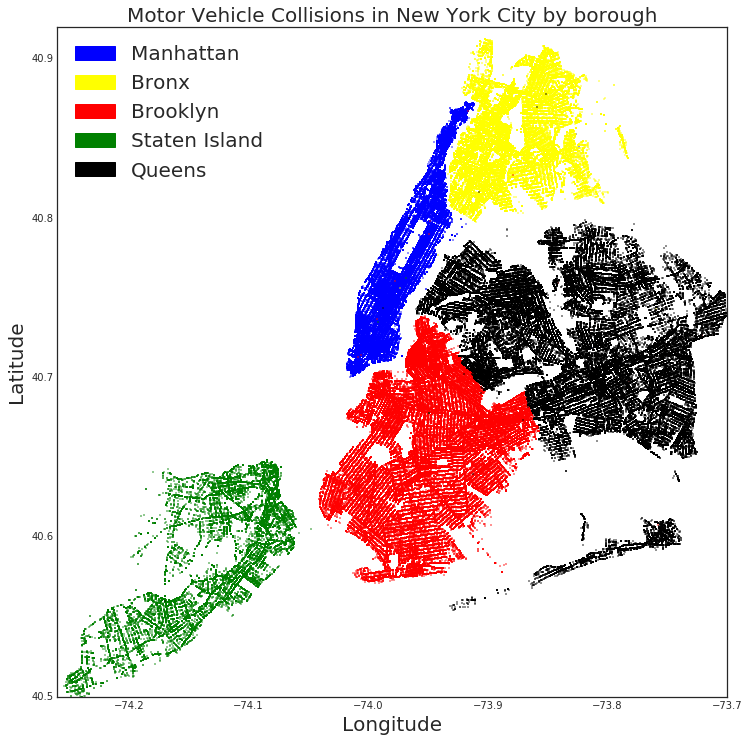

In [8]:
manhattan = collisions_pd[collisions_pd['Borough']=='MANHATTAN']
bronx = collisions_pd[collisions_pd['Borough']=='BRONX']
brooklyn = collisions_pd[collisions_pd['Borough']=='BROOKLYN']
staten = collisions_pd[collisions_pd['Borough']=='STATEN ISLAND']
queens = collisions_pd[collisions_pd['Borough']=='QUEENS']


#create scatterplots
plt.scatter(manhattan.Longitude, manhattan.Latitude, s=1, color='blue', marker ='.')
plt.scatter(bronx.Longitude, bronx.Latitude, s=1, color='yellow', marker ='.')
plt.scatter(brooklyn.Longitude, brooklyn.Latitude, color='red', s=1, marker ='.')
plt.scatter(staten.Longitude, staten.Latitude, s=1, color='green', marker ='.')
plt.scatter(queens.Longitude, queens.Latitude, s=1, color='black', marker ='.')

#create legend
blue_patch = mpatches.Patch(label='Manhattan', color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='Bronx')
red_patch = mpatches.Patch(color='red', label='Brooklyn')
green_patch = mpatches.Patch(color='green', label='Staten Island')
black_patch = mpatches.Patch(color='black', label='Queens')
plt.legend([blue_patch, yellow_patch, red_patch, green_patch, black_patch],
           ('Manhattan', 'Bronx', 'Brooklyn', 'Staten Island', 'Queens'), 
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Motor Vehicle Collisions in New York City by borough', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

Which neighborhoods have the highest total number of crashes? 

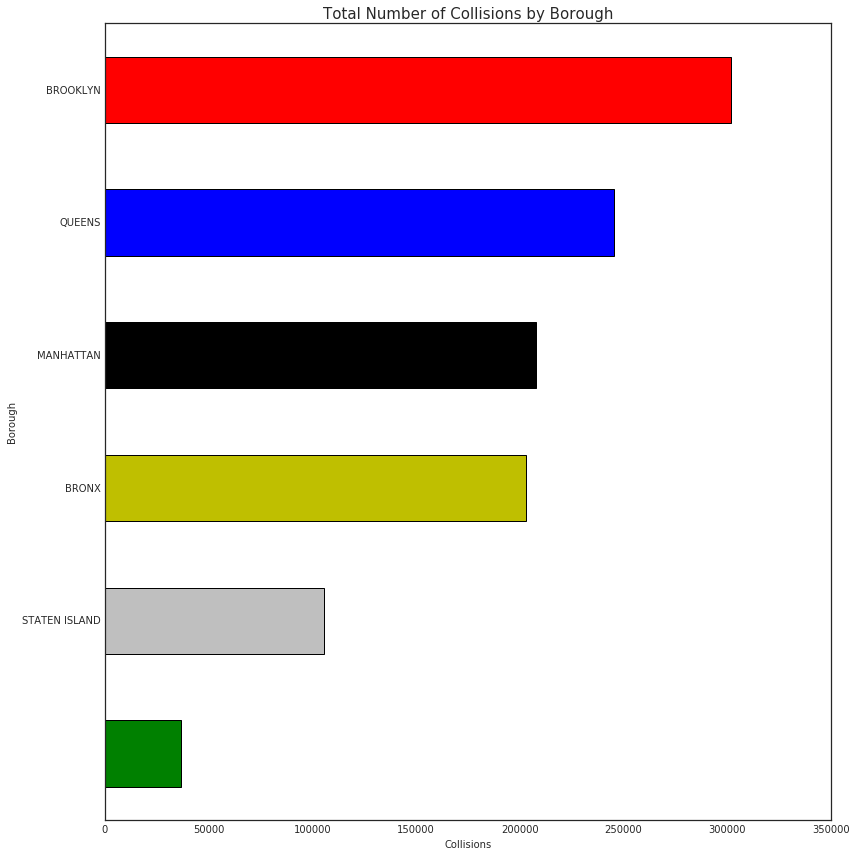

In [9]:
borough = collisions_df.groupBy('BOROUGH').count().sort('count').toPandas().iloc[1:,:]
borough['BOROUGH'] = [u'STATEN ISLAND', u'BRONX', u'MANHATTAN', u'QUEENS',
       u'BROOKLYN', 'NONE']
colors = ['g','0.75','y','k','b','r']
borough.sort_values(by='count', ascending=True)['count'].plot.barh(color=colors)
plt.xlabel('Collisions')
plt.ylabel('Borough')
plt.title('Total Number of Collisions by Borough', size=15)
plt.yticks(range(1,6),borough['BOROUGH'])
plt.tight_layout()
plt.show()

The bar graph clearly shows that the most collisions happen in Brooklyn and the least on Staten Island.

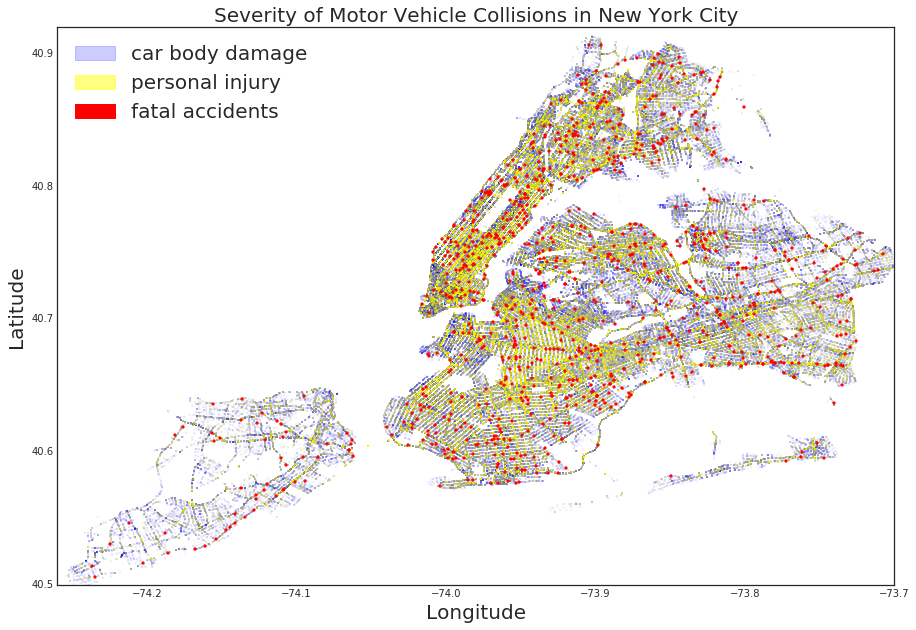

In [10]:
#adjust settings
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(nothing_pd.Longitude, nothing_pd.Latitude, alpha=0.04, s=1, color='blue')
plt.scatter(injured_pd.Longitude, injured_pd.Latitude, alpha=0.1, s=1, color='yellow')
plt.scatter(killed_pd.Longitude, killed_pd.Latitude, color='red', s=5)

#create legend
blue_patch = mpatches.Patch( label='car body damage', alpha=0.2, color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='personal injury', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='lethal accidents')
plt.legend([blue_patch, yellow_patch, red_patch],('car body damage', 'personal injury', 'fatal accidents'), 
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Severity of Motor Vehicle Collisions in New York City', size=20)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.savefig('anothertry.png')

plt.show()

The resulting scatter plot shows that there are fatal accident hot spots throughout the city. You can see that in some areas car body damage is prevalent, while in other areas personal injuries happen more often.

<a id="data_cleaning"></a> 
## Clean and shape the data

After using scatter plots to analyze certain characteristics of the raw data set, you will now learn how to clean and shape the data set to enable more plotting and further analysis. 

Begin by looking at the column names again to better assess which information you can use:


In [11]:
collisions_header_list = collisions.columns[:-4]
collisions_header_list.remove("CONTRIBUTING FACTOR VEHICLE 4")
collisions_header_list.remove("CONTRIBUTING FACTOR VEHICLE 3")
collisions_header_list.remove("CONTRIBUTING FACTOR VEHICLE 5")
collisions_df = collisions_df.dropna(how='any', subset=['ON STREET NAME', 'BOROUGH'])[collisions_header_list]
collisions_df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738884 entries, 0 to 738883
Data columns (total 22 columns):
DATE                             738884 non-null object
TIME                             738884 non-null object
BOROUGH                          738884 non-null object
ZIP CODE                         738825 non-null object
LATITUDE                         717862 non-null object
LONGITUDE                        717862 non-null object
LOCATION                         717862 non-null object
ON STREET NAME                   738884 non-null object
CROSS STREET NAME                738884 non-null object
OFF STREET NAME                  58608 non-null object
NUMBER OF PERSONS INJURED        738884 non-null object
NUMBER OF PERSONS KILLED         738883 non-null object
NUMBER OF PEDESTRIANS INJURED    738883 non-null object
NUMBER OF PEDESTRIANS KILLED     738883 non-null object
NUMBER OF CYCLIST INJURED        738884 non-null object
NUMBER OF CYCLIST KILLED         738884 non-null o

### Spatial and temporal normalization by using Spark

To obtain a consistent representation of the spatial and temporal information about collisions, you have to normalize the data. Normalization is the process of organizing the columns (attributes) and tables (relations) to minimize data redundancy. This step will help you in future analyses.

In [12]:
delchars = ''.join(c for c in map(chr, range(256)) if not c.isalnum())
deltable = dict((ord(char), None) for char in delchars) # Python2 unicode
normalization_code = {
    'avenue':'av',
    'ave':'av',
    'avnue': 'av',
    'street': 'st',
    'road': 'rd',
    'boulevard': 'blvd',
    'place': 'pl',
    'plaza': 'pl',
    'square': 'sq',
    'drive': 'dr',
    'lane': 'ln',
    'parkway': 'pkwy',
    'turnpike': 'tp',
    'terrace': 'ter',
    '1st': '1',
    '2nd':'2',
    '3rd': '3',
    '1th': '1',
    '2th': '2',
    '3th': '3',
    '4th': '4',
    '5th': '5',
    '6th': '6',
    '7th': '7', 
    '8th': '8',
    '9th': '9',
    '0th': '0',
    'west ': 'w ',
    'north ': 'n ',
    'east ': 'e ',
    'south ': 's ',
}
def normalize_street(s):
    # Lowercase
    s = s.lower()

    # Delete all non-alphanumeric characters
    if isinstance(s, unicode):
        s = s.translate(deltable)
    else:
        s = s.translate(None, delchars) # Python 2

    # Replace common abbreviations
    for k in sorted(normalization_code.keys()):
        s = s.replace(k, normalization_code[k])

    # Only keep ascii chars
    s = s.encode('ascii', errors='ignore').decode()

    return s

def row_parser(row):
    from datetime import datetime
    
    """
    Spatial and Temporal Normalization
    Returns the location, borough, year, month, day, hour; removes nonalphanumeric characters
    """
    # create a row dictionary
    row_dict = row.asDict()
    
    # temporal
    ## date
    temp = row_dict['DATE']
    hr = row_dict['TIME'].split(":")[0]
    try:
        a = datetime.strptime(temp+" "+hr, '%m/%d/%Y %H')
        dates =  [a]
    except:
        a = datetime.now()
        dates = [a]
    
    # location and borough
    location = normalize_street(row_dict['ON STREET NAME'])
    borough = row_dict['BOROUGH'].lower()
    
    
    # other cols
    others = [row_dict[column] for column in collisions_header_list
             if column not in ["ON STREET NAME", "OFF STREET NAME", "CROSS STREET NAME", "BOROUGH", "DATE", "TIME"]]

       

    # return everything together
    return dates + [location] + [borough] + others


Now apply. 

In [13]:
collisions_out_row = Row(*(["Time", "Street", "Borough"] + [c for c in collisions_header_list
                      if c not in ["ON STREET NAME", "OFF STREET NAME", "CROSS STREET NAME", "BOROUGH", "DATE", "TIME"]]))
collisions_out_index = list(collisions_out_row)

collisions_out = collisions_df.rdd.map(
    lambda row: collisions_out_row(*(row_parser(row)))).toDF()

In [14]:
collisions_out.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738884 entries, 0 to 738883
Data columns (total 19 columns):
Time                             738884 non-null datetime64[ns]
Street                           738884 non-null object
Borough                          738884 non-null object
ZIP CODE                         738825 non-null object
LATITUDE                         717862 non-null object
LONGITUDE                        717862 non-null object
LOCATION                         717862 non-null object
NUMBER OF PERSONS INJURED        738884 non-null object
NUMBER OF PERSONS KILLED         738883 non-null object
NUMBER OF PEDESTRIANS INJURED    738883 non-null object
NUMBER OF PEDESTRIANS KILLED     738883 non-null object
NUMBER OF CYCLIST INJURED        738884 non-null object
NUMBER OF CYCLIST KILLED         738884 non-null object
NUMBER OF MOTORIST INJURED       738884 non-null object
NUMBER OF MOTORIST KILLED        738883 non-null object
CONTRIBUTING FACTOR VEHICLE 1    735624 n

### Investigating data attributes

You can draw information from your data by examining the attributes in the data set and finding out how useful they are. 

Begin by plotting the contributing factors of an accident:

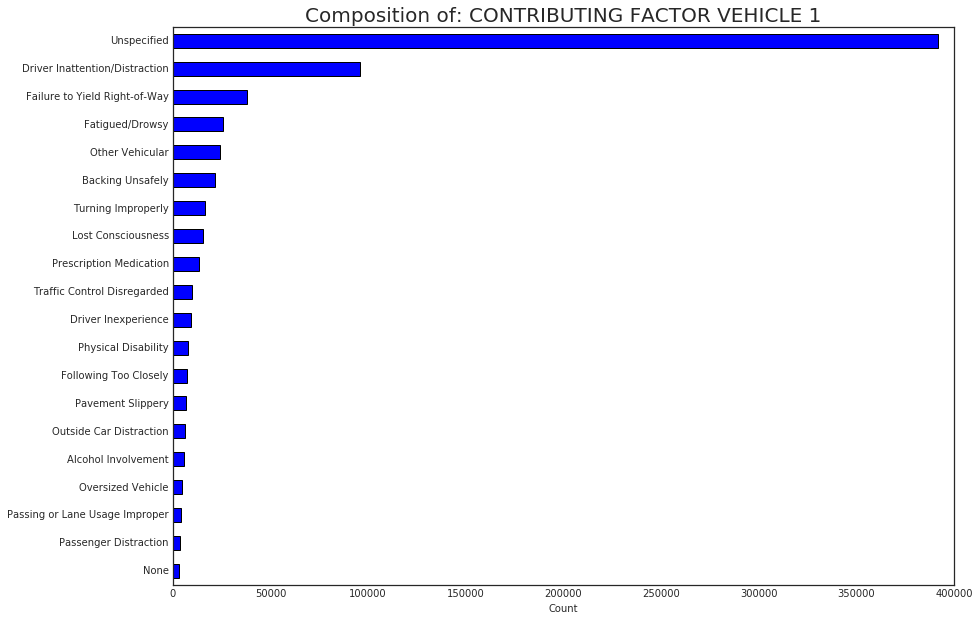

In [15]:
from pyspark.sql.functions import desc

collisions_out_df = collisions_out

factor = collisions_out_df.groupBy('CONTRIBUTING FACTOR VEHICLE 1').count().sort(desc('count')).toPandas()
factor = factor[0:20].sort_index(ascending=False)
factor.plot(kind='barh', legend=False, color='blue', figsize=(14,10))
plt.title('Composition of: ' + 'CONTRIBUTING FACTOR VEHICLE 1', size=20)
plt.xlabel('Count')
plt.yticks(range(len(factor))[::-1], factor['CONTRIBUTING FACTOR VEHICLE 1'][::-1])
plt.show()

Running the code cell above shows you that the contributing factor can't be specified in most cases. However, factors like distraction, failure to yield right-of-way, and fatigue could have an influence.

### Sorting accidents by vehicle type
The data set has entries for a large number of car types. To avoid inconclusive results because the  number of car types is too large, regroup the car types into main categories like auto, bus, truck, taxi or other:

In [16]:
from collections import Counter

vehicletypecode, vehicletypecoderange = 'VEHICLE TYPE CODE ', range(1,6)
grouping = {
    'TAXI': 'Taxi',
    'AMBULANCE': 'Other',
    'BICYCLE': 'Other',
    'BUS': 'Bus',
    'FIRE TRUCK': 'Other', 
    'LARGE COM VEH(6 OR MORE TIRES)': 'Truck',
    'LIVERY VEHICLE': 'Truck',
    'MOTORCYCLE': 'Other', 
    'OTHER': 'Other',
    'PASSENGER VEHICLE': 'Auto',
    'PICK-UP TRUCK': 'Other',
    'PEDICAB': 'Other', 
    'SCOOTER': 'Other',
    'SMALL COM VEH(4 TIRES) ': 'Truck',
    'SPORT UTILITY / STATION WAGON': 'Auto', 
    'UNKNOWN': 'Other',
    'VAN': 'Auto',
    'UNSPECIFIED': 'Other',
    None: None
}

collisions_out_categories = collisions_out.rdd.map(lambda row:
                   collisions_out_row(*[grouping[row[i]] if collisions_out_index[i].startswith("VEHICLE TYPE CODE")
                                                    else row[i] for i in range(len(row))])
                  ).toDF()

In [17]:
collisions_transformed_row = Row(*(["Time", "Street", "Borough", "Injured",
                                                "Killed", "Auto", "Bus",
                                                "Truck", "Taxi", "Other", ]))

def transform_involved(row):
    counts = Counter([row[i] for i in range(len(row)) if collisions_out_index[i].startswith("VEHICLE TYPE CODE")])
    return collisions_transformed_row(*([row.asDict()[c] for c in ["Time", "Street", "Borough",
                                                                      "NUMBER OF PERSONS INJURED",
                                                                      "NUMBER OF PERSONS KILLED"]] + 
                                       [counts[x] if x in counts else 0
                                           for x in ['Auto', 'Bus','Truck', 'Taxi', 'Other']]))

collisions_transformed = collisions_out_categories.rdd.map(transform_involved).toDF()

In [18]:
collisions_transformed_boolean_row = Row(*(["Time", "Street", "Borough",
                                                        "AccidentsWithInjuries",
                                                        "AccidentswithDeaths", "Auto", "Bus",
                                                        "Truck", "Taxi", "Other",
                                                        "Injured", "Killed"]))

collisions_transformed_boolean = collisions_transformed.rdd.map(
    lambda row: collisions_transformed_boolean_row(*([int(row.asDict()[c] > 0) if c in ["Injured",
                                                "Killed"] else row.asDict()[c]
                                                      for c in list(collisions_transformed_row)] + 
                                                    [row.Injured, row.Killed])))

In [19]:
collisions_transformed_boolean.take(1)

[Row(Time=datetime.datetime(2017, 8, 25, 0, 0), Street=u'w43st', Borough=u'manhattan', AccidentsWithInjuries=1, AccidentswithDeaths=1, Auto=1, Bus=0, Truck=0, Taxi=0, Other=0, Injured=u'0', Killed=u'0')]

In [20]:
aggregation_columns = {x:"sum" for x in ["AccidentsWithInjuries", "AccidentswithDeaths",
                                    "Auto", "Bus", "Truck", "Taxi", "Other", "Injured", "Killed"]}
aggregation_columns.update({"*":"count"})

collisions_grouped = collisions_transformed_boolean.toDF().groupBy(
    "Time", "Street", "Borough").agg(aggregation_columns)

# rename columns names
for c in collisions_grouped.columns:
    if c.startswith("sum") or c.startswith("SUM"):
        collisions_grouped = collisions_grouped.withColumnRenamed(c, c[4:-1])
    elif c.startswith("count") or c.startswith("COUNT"):
        collisions_grouped = collisions_grouped.withColumnRenamed(c, "NumberOfAccidents")

In [21]:
collisions_grouped.take(1)

[Row(Time=datetime.datetime(2017, 8, 25, 10, 0), Street=u'courtst', Borough=u'brooklyn', Other=0, NumberOfAccidents=1, Killed=0.0, Auto=1, Injured=0.0, AccidentswithDeaths=1, Taxi=0, AccidentsWithInjuries=1, Truck=0, Bus=0)]

In [22]:
collisions_final_row = pyspark.sql.Row(*(["Year", "Month", "Day", "Hour"] + collisions_grouped.columns[1:]))
collisions_final = collisions_grouped.rdd.map(lambda row: collisions_final_row(*([row.Time.year, row.Time.month,
                                                                              row.Time.day, row.Time.hour] +
                                                                             [row.asDict()[x]
                                                                              for x in collisions_final_row[4:]]))).toDF()

In [23]:
collisions_final.take(1)

[Row(Year=2015, Month=2, Day=17, Hour=10, Street=u'parkavsouth', Borough=u'manhattan', Other=0, NumberOfAccidents=1, Killed=0.0, Auto=0, Injured=0.0, AccidentswithDeaths=1, Taxi=0, AccidentsWithInjuries=1, Truck=1, Bus=0)]

### Determine the streets with the most collisions

Find the top ten streets in New York where the most vehicle collisions occurred. Display the results in a bar graph and as a scatter plot:

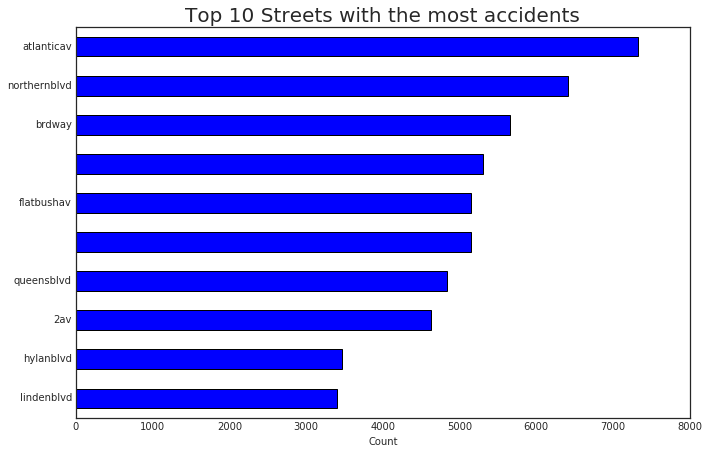

In [24]:
from pyspark.sql import functions as F
collisions_final_df = collisions_final
plottingdf = collisions_final_df.groupBy("Borough", "Street").agg(F.sum("NumberOfAccidents").alias("sum(NumberOfAccidents)")).\
sort(F.desc('sum(NumberOfAccidents)')).limit(10).toPandas()
plottingdf[['sum(NumberOfAccidents)']].plot(kind='barh', figsize=(11,7), legend=False)
plt.title('Top 10 Streets with the most accidents', size=20)
plt.xlabel('Count')
plt.yticks(range(10), plottingdf['Street'])
plt.gca().invert_yaxis()
plt.show()

Now you can add the information about the top 10 streets into the scatter plot.

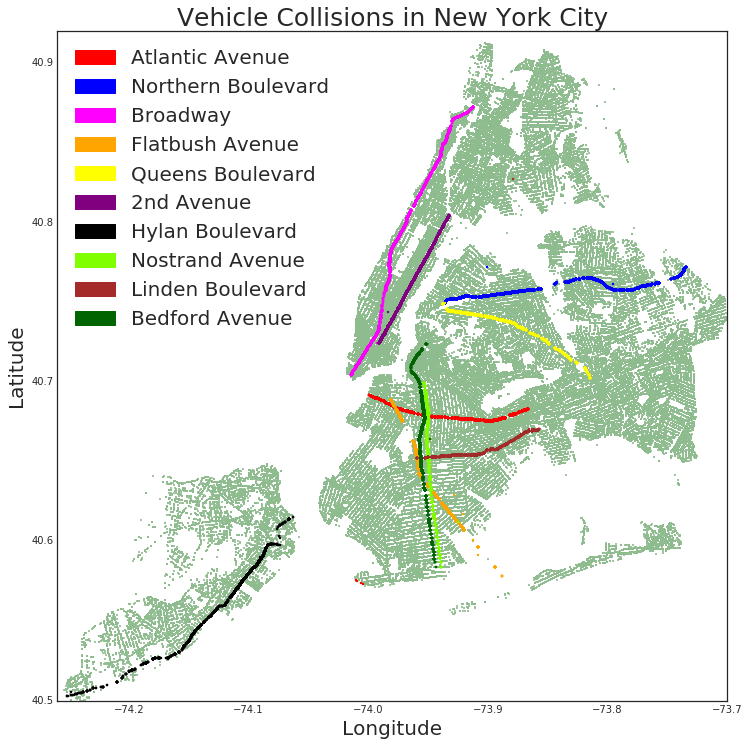

In [25]:
data1 = collisions_out_df[['Borough', 'Street', 'LATITUDE', 'LONGITUDE']].toPandas()

collisions1 = data1[np.logical_and(data1['Street']=='atlanticav', data1['Borough']=='brooklyn')]
collisions2 = data1[np.logical_and(data1['Street']=='northernblvd', data1['Borough']=='queens')]
collisions3 = data1[np.logical_and(data1['Street']=='brdway', data1['Borough']=='manhattan')]
collisions4 = data1[np.logical_and(data1['Street']=='flatbushav', data1['Borough']=='brooklyn')]
collisions5 = data1[np.logical_and(data1['Street']=='queensblvd', data1['Borough']=='queens')]
collisions6 = data1[np.logical_and(data1['Street']=='2av', data1['Borough']=='manhattan')]
collisions7 = data1[np.logical_and(data1['Street']=='hylanblvd', data1['Borough']=='staten island')]
collisions8 = data1[np.logical_and(data1['Street']=='nostrandav', data1['Borough']=='brooklyn')]
collisions9 = data1[np.logical_and(data1['Street']=='lindenblvd', data1['Borough']=='brooklyn')]
collisions10 = data1[np.logical_and(data1['Street']=='bedfordav', data1['Borough']=='brooklyn')]

#create scatterplots
plt.scatter(data1.LONGITUDE, data1.LATITUDE, s=1, color='darkseagreen')
plt.scatter(collisions1.LONGITUDE, collisions1.LATITUDE, s=2, color='red')
plt.scatter(collisions2.LONGITUDE, collisions2.LATITUDE, color='blue', s=2)
plt.scatter(collisions3.LONGITUDE, collisions3.LATITUDE, s=2, color='magenta')
plt.scatter(collisions4.LONGITUDE, collisions4.LATITUDE, color='orange', s=2)
plt.scatter(collisions5.LONGITUDE, collisions5.LATITUDE, s=2, color='yellow')
plt.scatter(collisions6.LONGITUDE, collisions6.LATITUDE, color='purple', s=2)
plt.scatter(collisions7.LONGITUDE, collisions7.LATITUDE, s=2, color='black')
plt.scatter(collisions8.LONGITUDE, collisions8.LATITUDE, color='chartreuse', s=2)
plt.scatter(collisions9.LONGITUDE, collisions9.LATITUDE, s=2, color='brown')
plt.scatter(collisions10.LONGITUDE, collisions10.LATITUDE, color='darkgreen', s=2)


#create legend
a_patch = mpatches.Patch(color='red', label='Atlantic Avenue')
b_patch = mpatches.Patch(color='blue', label='Northern Boulevard')
c_patch = mpatches.Patch(color='magenta', label='Broadway')
d_patch = mpatches.Patch(color='orange', label='Flatbush Avenue')
e_patch = mpatches.Patch(color='yellow', label='Queens Boulevard')
f_patch = mpatches.Patch(color='purple', label='2nd Avenue')
g_patch = mpatches.Patch(color='black', label='Hylan Boulevard')
h_patch = mpatches.Patch(color='chartreuse', label='Nostrand Avenue')
i_patch = mpatches.Patch(color='brown', label='Linden Boulevard')
j_patch = mpatches.Patch(color='darkgreen', label='Bedford Avenue')

plt.legend([a_patch, b_patch, c_patch, d_patch, e_patch, f_patch, g_patch, h_patch, i_patch, j_patch],
           ('Atlantic Avenue', 'Northern Boulevard', 'Broadway', 'Flatbush Avenue', 'Queens Boulevard', '2nd Avenue',
            'Hylan Boulevard', 'Nostrand Avenue', 'Linden Boulevard', 'Bedford Avenue'), 
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)
plt.show()

### Determining when the most collisions occurred

Now find out at what time of the day the most accidents occurred and see if you can detect any interesting patterns by running the following cell:

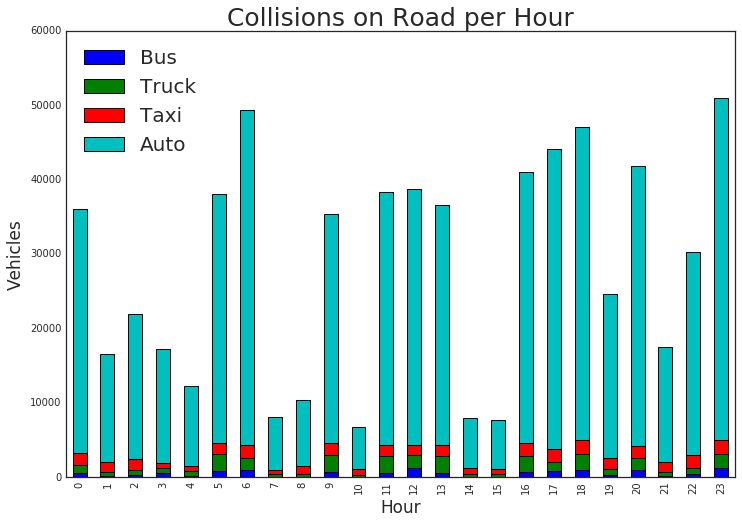

In [26]:
from pyspark.sql import functions as F

hourplot = collisions_final_df[['Bus','Truck','Taxi','Other','Hour','Auto']].groupBy('Hour')\
.agg(F.sum("Bus").alias("Bus"), F.sum("Truck").alias("Truck"), F.sum("Taxi").alias("Taxi"),\
F.sum("Other").alias("Other"),F.sum("Auto").alias("Auto")).toPandas()

hourplot[['Bus', 'Truck', 'Taxi', 'Auto']].plot(stacked=True, kind='bar',figsize=(12,8), alpha=1)
#'SUM(Other)',
plt.xlabel('Hour', size=17)
plt.ylabel('Vehicles', size=17)
plt.legend(loc='best', prop={'size':20}, framealpha=0) 
plt.title('Collisions on Road per Hour', size=25)
plt.show()

This plot shows collisions spread across a day, with peaks during the morning and afternoon rush hours. You can see that significantly more collisions occurred during the afternoon rush hour than during the morning rush hour. Also, the most collisions involve cars by far, while buses, taxis, and trucks are involved in accidents a lot less frequently.

<a id="summary"></a>
## Summary

This notebook showed you how to analyze car vehicle accidents based on accident reports for New York and how you can use this information to learn more about the causes for collisions. If you extract  this type of information from the data, you can use it to help develop measures for preventing  vehicle accidents in accident hotspots.

### Author
Sven Hafeneger is a member of the Data Science Experience development team at IBM Analytics in Germany. He holds a M.Sc. in Bioinformatics and is passionate about data analysis, machine learning and the Python ecosystem for data science. 

Copyright © IBM Corp. 2016, 2017. This notebook and its source code are released under the terms of the MIT License.